<a href="https://colab.research.google.com/github/slneha/AIPI590_Fall2025/blob/main/Assignment4/Explainable_Techniques_II.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:
!pip install PyALE

In [1]:
import warnings, numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.inspection import PartialDependenceDisplay

warnings.filterwarnings("ignore")
np.random.seed(42)


In [2]:
CANDIDATE_URLS = [
    # UCI mirror(s) for the PRSA Beijing PM2.5 dataset
    "https://archive.ics.uci.edu/ml/machine-learning-databases/00381/PRSA_data_2010.1.1-2014.12.31.csv",
    "https://archive.ics.uci.edu/ml/machine-learning-databases/00381/BeijingPM20100101_20151231.csv",
]

CSV_PATH = None
#this is generated by Chatgpt
for url in CANDIDATE_URLS:
    try:
        df = pd.read_csv(url)
        CSV_PATH = url
        print(f"Loaded from {url}")
        break
    except Exception as e:
        print(f"Could not load from {url}: {e}")

df


Loaded from https://archive.ics.uci.edu/ml/machine-learning-databases/00381/PRSA_data_2010.1.1-2014.12.31.csv


,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
0,1,2010,1,1,0,NaN,-21,-11.0,1021.0,NW,1.79,0,0
1,2,2010,1,1,1,NaN,-21,-12.0,1020.0,NW,4.92,0,0
2,3,2010,1,1,2,NaN,-21,-11.0,1019.0,NW,6.71,0,0
3,4,2010,1,1,3,NaN,-21,-14.0,1019.0,NW,9.84,0,0
4,5,2010,1,1,4,NaN,-20,-12.0,1018.0,NW,12.97,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
43819,43820,2014,12,31,19,8.0,-23,-2.0,1034.0,NW,231.97,0,0
43820,43821,2014,12,31,20,10.0,-22,-3.0,1034.0,NW,237.78,0,0
43821,43822,2014,12,31,21,10.0,-22,-3.0,1034.0,NW,242.70,0,0
43822,43823,2014,12,31,22,8.0,-22,-4.0,1034.0,NW,246.72,0,0


In [3]:
#ChatGPT is used for some of this, including datetime parsing, NA handling, and converting pm2.5 column

# Standardize column names
df.columns = [c.strip().lower().replace(" ", "_") for c in df.columns]

# Some variants call pm2.5 as 'pm2.5' or 'pm2_5'; normalize:
if 'pm2.5' in df.columns:
    df.rename(columns={'pm2.5': 'pm25'}, inplace=True)
elif 'pm2_5' in df.columns:
    df.rename(columns={'pm2_5': 'pm25'}, inplace=True)

# Parse a datetime if year/month/day/hour exist
if set(['year','month','day','hour']).issubset(df.columns):
    df['datetime'] = pd.to_datetime(df[['year','month','day','hour']].rename(columns={'year':'year','month':'month','day':'day','hour':'hour'}))
elif 'date' in df.columns and 'hour' in df.columns:
    df['datetime'] = pd.to_datetime(df['date']) + pd.to_timedelta(df['hour'], unit='h')
else:
    df['datetime'] = pd.to_datetime(df.index, unit='h', errors='coerce')

# Drop non-predictive IDs
df.drop(columns=['no'], inplace=True)

# Basic NA handling: -999 / -200 are known sentinel missing in some air datasets
df.replace([-999, -200], np.nan, inplace=True)

# Keep rows with a valid target
df = df[df['pm25'].notna()].copy()

df['month'] = df['datetime'].dt.month
df['hour'] = df['datetime'].dt.hour
df['is_weekend'] = (df['datetime'].dt.weekday >= 5).astype(int)

df['day_of_week'] = df['datetime'].dt.day_name()

def assign_time_of_day(hour):
    if 5 <= hour < 12:
        return "Morning"
    elif 12 <= hour < 17:
        return "Afternoon"
    elif 17 <= hour < 21:
        return "Evening"
    else:
        return "Night"

df['time_of_day'] = df['hour'].apply(assign_time_of_day)

df.describe(include='all').T.head(25)


,count,unique,top,freq,mean,min,25%,50%,75%,max,std
year,41757.0,NaN,NaN,NaN,2012.042771,2010.0,2011.0,2012.0,2013.0,2014.0,1.415311
month,41757.0,NaN,NaN,NaN,6.513758,1.0,4.0,7.0,10.0,12.0,3.454199
day,41757.0,NaN,NaN,NaN,15.685514,1.0,8.0,16.0,23.0,31.0,8.785539
hour,41757.0,NaN,NaN,NaN,11.502311,0.0,5.0,12.0,18.0,23.0,6.924848
pm25,41757.0,NaN,NaN,NaN,98.613215,0.0,29.0,72.0,137.0,994.0,92.050387
dewp,41757.0,NaN,NaN,NaN,1.750174,-40.0,-10.0,2.0,15.0,28.0,14.433658
temp,41757.0,NaN,NaN,NaN,12.401561,-19.0,2.0,14.0,23.0,42.0,12.175215
pres,41757.0,NaN,NaN,NaN,1016.442896,991.0,1008.0,1016.0,1025.0,1046.0,10.300733
cbwd,41757,4,SE,14573,NaN,NaN,NaN,NaN,NaN,NaN,NaN
iws,41757.0,NaN,NaN,NaN,23.866747,0.45,1.79,5.37,21.91,565.49,49.617495


In [4]:
na_cnt = df.isna().sum()
na_pct = (na_cnt / len(df) * 100).round(2)
na_report = pd.DataFrame({"missing_count": na_cnt, "missing_%": na_pct})
display(na_report)

,missing_count,missing_%
year,0,0.0
month,0,0.0
day,0,0.0
hour,0,0.0
pm25,0,0.0
dewp,0,0.0
temp,0,0.0
pres,0,0.0
cbwd,0,0.0
iws,0,0.0


In [5]:
#for preventing data leakage
df_sorted = df.sort_values('datetime')
split_idx = int(len(df_sorted) * 0.8)

train_idx = df_sorted.index[:split_idx]
test_idx  = df_sorted.index[split_idx:]

X = df.drop(columns=['pm25','datetime'])  # predictors, datetime is dropped as feature engineering for day, month, year etc are used
y = df['pm25']

X_train, X_test = X.loc[train_idx], X.loc[test_idx]
y_train, y_test = y.loc[train_idx], y.loc[test_idx]


In [6]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor

numeric_feats = ['dewp','temp','pres','iws','is','ir','month','hour']
cat_feats = ['cbwd','is_weekend','day_of_week','time_of_day']


#Numeric: impute missing values with median, then scale to standardize magnitudes
#Categorical: impute missing with most frequent value, then one-hot encode categories
preprocess = ColumnTransformer(
    transformers=[
        ("num", Pipeline([
            ("imputer", SimpleImputer(strategy="median")),
            ("scaler", StandardScaler())
        ]), numeric_feats),
        ("cat", Pipeline([
            ("imputer", SimpleImputer(strategy="most_frequent")),
            ("onehot", OneHotEncoder(handle_unknown="ignore"))
        ]), cat_feats),
    ],
    remainder="drop"
)

model = RandomForestRegressor(n_estimators=300, random_state=42, n_jobs=-1)

pipe = Pipeline(steps=[("prep", preprocess), ("rf", model)])
pipe.fit(X_train, y_train)


Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['dewp', 'temp', 'pres',
                                                   'iws', 'is', 'ir', 'month',
                                                   'hour']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['cbwd', 'is_weekend',
                                                   'day_of_week',
                                                   'time_of_day'])])),
                ('rf',
                 RandomForestRegressor(n_estimators=300, n_jobs=-1,
                                       random_state=42))])

In [15]:
preds = pipe.predict(X_test)
print("R^2:", r2_score(y_test, preds))
print("MAE:", mean_absolute_error(y_test, preds))


R^2: 0.4647357804168796
MAE: 47.751836903431546


#Correlation

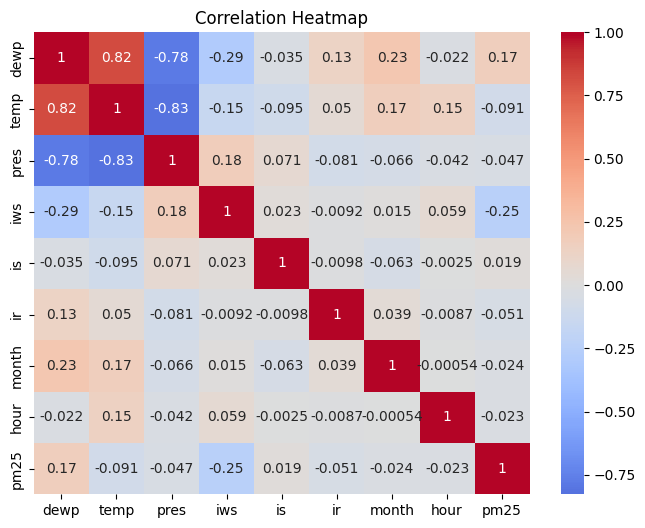

In [8]:
corr = df[numeric_feats + ['pm25']].corr()
plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, cmap="coolwarm", center=0)
plt.title("Correlation Heatmap")
plt.show()


The correlation heatmap provides an overview of the relationships between numerical features and the target variable, PM2.5 concentration. In this dataset, variables including temperature and dew point are strongly correlated, which makes sense since both reflect atmospheric moisture conditions. This correlation is important as highly collinear features can distort global interpretation methods like PDP, as the model may be evaluated on unrealistic feature combinations. The correlation analysis also highlights weaker but still relevant links, such as the negative association between wind speed and PM2.5, reflecting how dispersion reduces pollution. These results can also be used to augment the explanations for the interpretable techniques in upcoming code cells.

In [9]:
# Use only numeric columns for PDP/ICE/ALE
numeric_for_pdp = [f for f in ['temp','dewp','pres','iws','hour','month'] if f in X_test.columns]
print("Numeric features for PDP/ICE/ALE:", numeric_for_pdp)

# Categorical columns handled separately
categorical_for_effects = [c for c in ['cbwd','day_of_week','time_of_day','is_weekend'] if c in X_test.columns]
print("Categorical features for bar-style effects:", categorical_for_effects)


Numeric features for PDP/ICE/ALE: ['temp', 'dewp', 'pres', 'iws', 'hour', 'month']
Categorical features for bar-style effects: ['cbwd', 'day_of_week', 'time_of_day', 'is_weekend']


#PDP

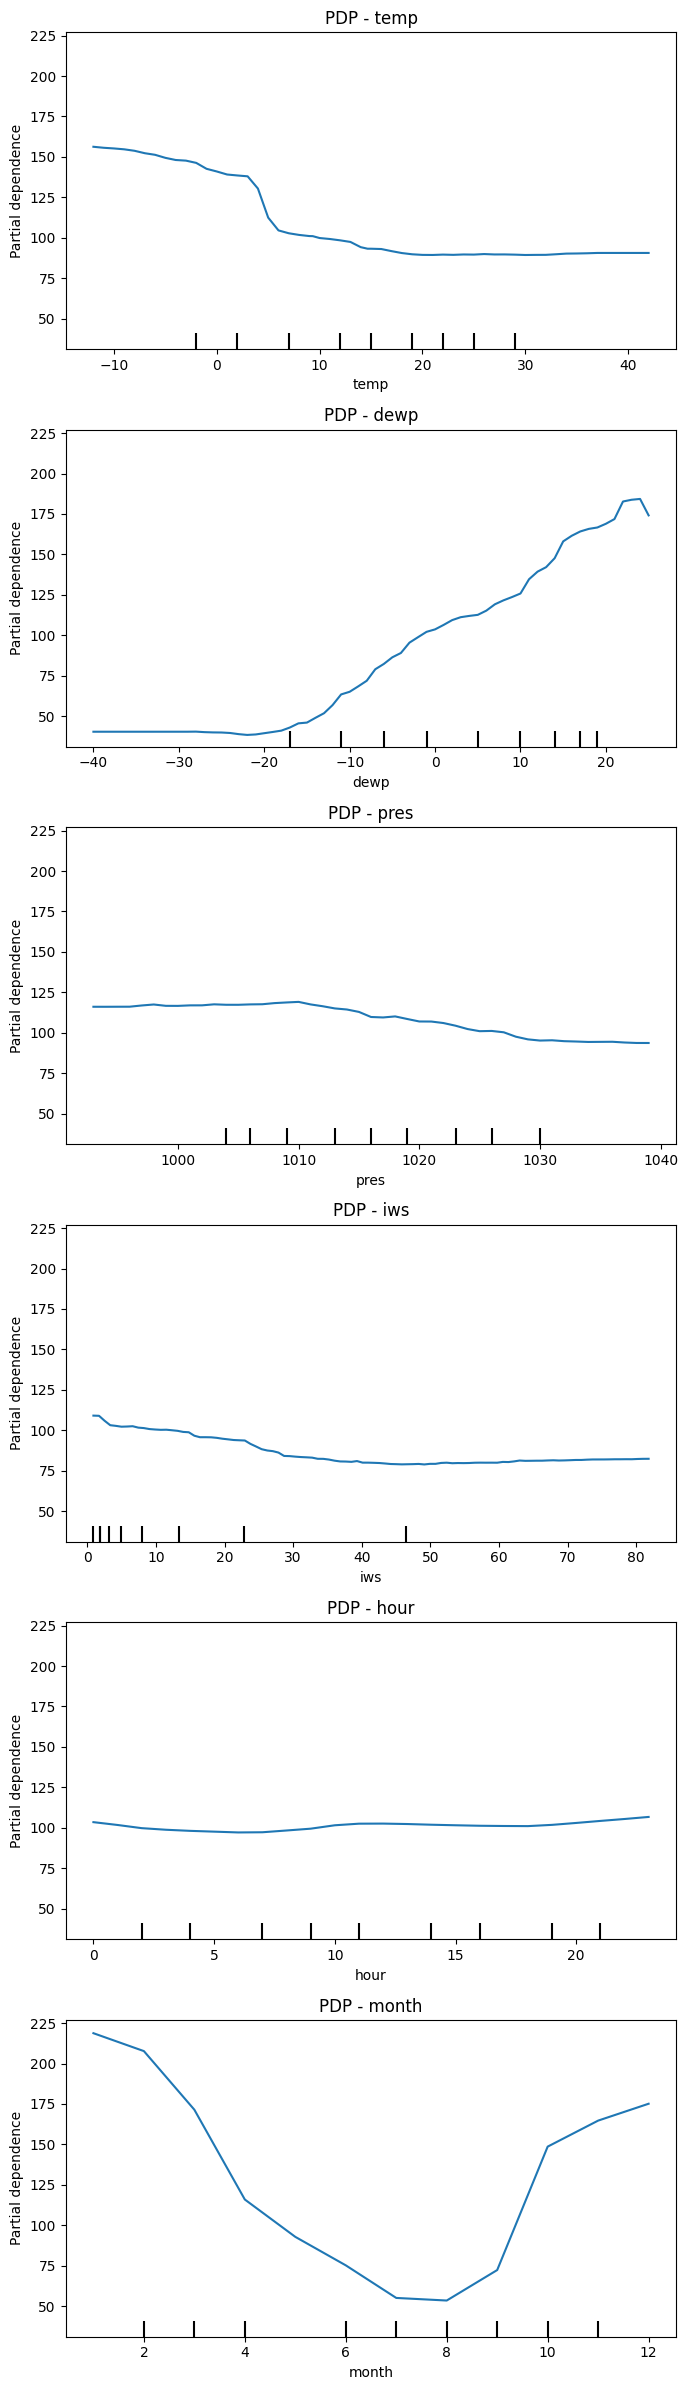

In [10]:
fig, ax = plt.subplots(len(numeric_for_pdp), 1, figsize=(7, 4*len(numeric_for_pdp)))
if len(numeric_for_pdp) == 1:
    ax = [ax]

PartialDependenceDisplay.from_estimator(
    pipe, X_test, features=numeric_for_pdp, kind="average", ax=ax
)
for a, f in zip(ax, numeric_for_pdp):
    a.set_title(f"PDP - {f}")
plt.tight_layout(); plt.show()


The PDP curves capture the average marginal effect of each feature on predicted PM2.5. For `iws`, the PDP slopes steadily downward, showing that stronger winds reduce predicted concentrations. `dewp` shows upward slopes, suggesting that warmer and more humid conditions increase pollution levels. Strangely, `temp` does not show an upward slope, which is likely due to PDP assuming that `temp` and `dewp` Time-related features (`hour`, `month`) display diurnal and seasonal cycles: pollution very minorly rises during evening/night hours and is higher in fall/winter months compared to summer and some months of spring. PDPs can be misleading when features are correlated, since they evaluate unrealistic feature combinations.  


#ICE

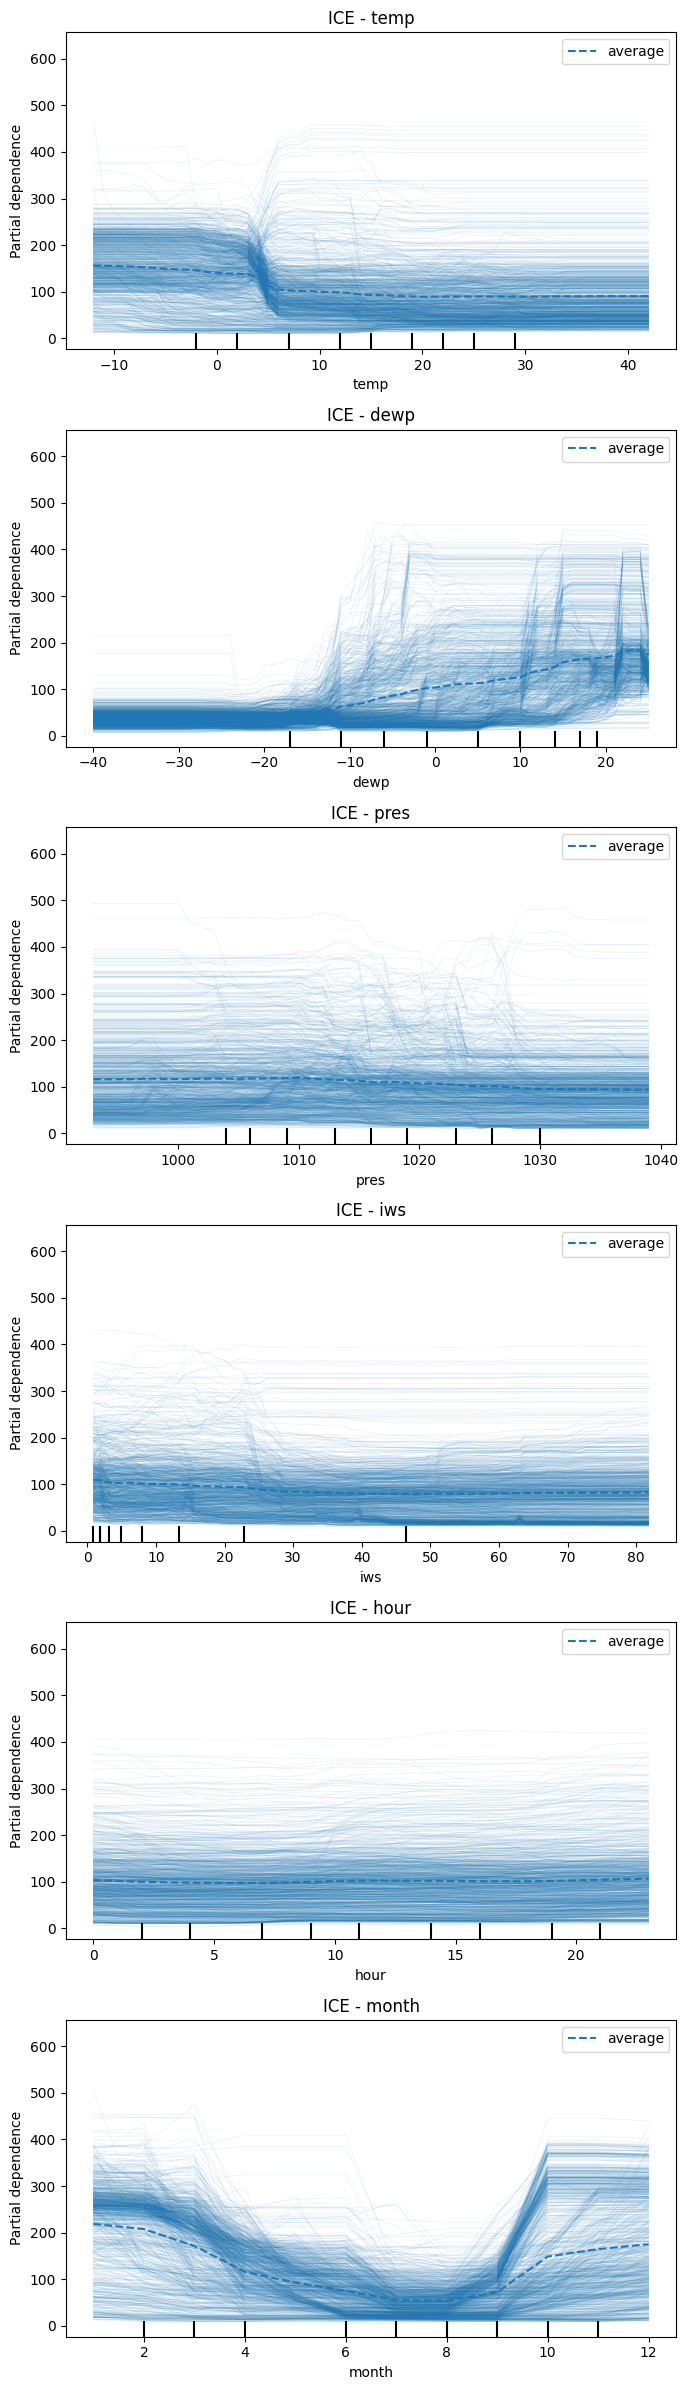

In [14]:
fig, ax = plt.subplots(len(numeric_for_pdp), 1, figsize=(7, 4*len(numeric_for_pdp)))
if len(numeric_for_pdp) == 1:
    ax = [ax]

PartialDependenceDisplay.from_estimator(
    pipe, X_test, features=numeric_for_pdp, kind="both",
    ice_lines_kw={'alpha':0.1}, ax=ax
)
for a, f in zip(ax, numeric_for_pdp):
    a.set_title(f"ICE - {f}")
plt.tight_layout(); plt.show()


While PDP gives the overall average marginal effect of each feature, ICE plots  a curve for each individual instance. For higher interpretability, the PDP line (global average) is overlaid on the plot. For `dewp`, the ICE curves diverge widely, showing that some samples show steep increases in PM2.5. For `temp`, other than a couple of outliers, most instances show a decrease between 0-10°C. The steepness of this effect is likely exaggerated by PDP's independence assumption, which ignores correlation with dew point and temperature. `hour`, `iws` does not seem to affect it much, the quality remains stable. However, while PDP shows `pres` as quite stable, the ICE plot shows that there is major variation between 1005-1025. This indicates that the relationship between pressure and PM2.5 is highly context-dependent. In some cases, high pressure coincides with stagnant air and poor dispersion; in others, it reflects clearer conditions, leading to lower PM2.5. ICE and PDP for `month` match with each other, showing that in fall/winter pollution is higher, and decreases in late spring/summer.


#ALE

##1D ALE

INFO:PyALE._ALE_generic:Continuous feature detected.


Computing ALE for temp


INFO:PyALE._ALE_generic:Continuous feature detected.


Computing ALE for dewp


INFO:PyALE._ALE_generic:Continuous feature detected.


Computing ALE for pres


INFO:PyALE._ALE_generic:Continuous feature detected.


Computing ALE for iws


INFO:PyALE._ALE_generic:Continuous feature detected.


Computing ALE for hour


INFO:PyALE._ALE_generic:Discrete feature detected.


Computing ALE for month


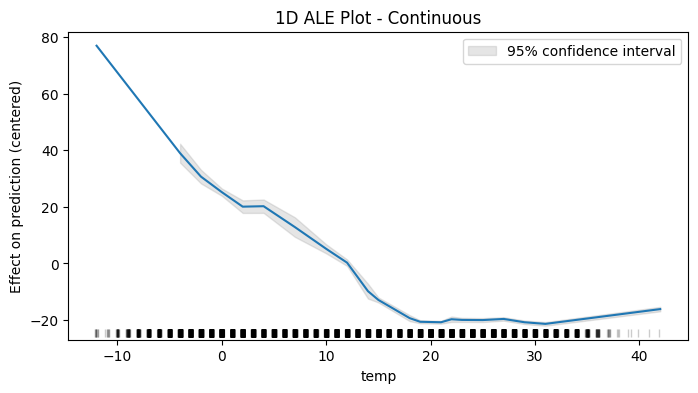

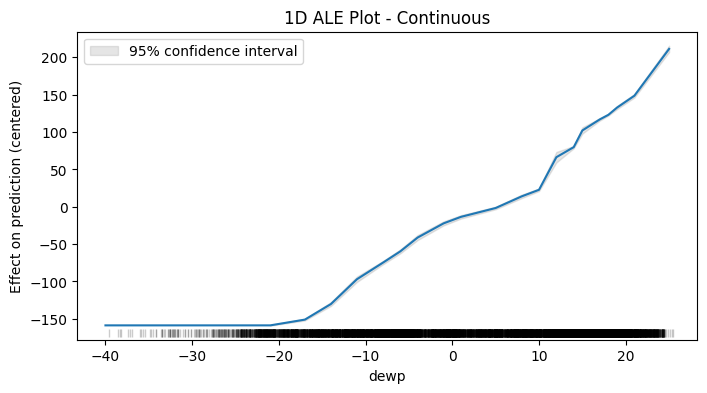

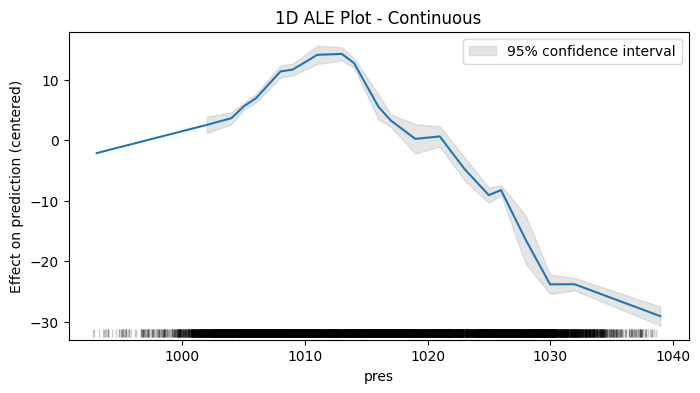

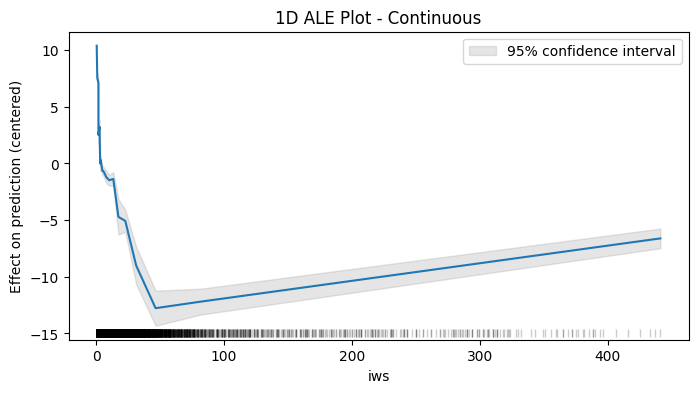

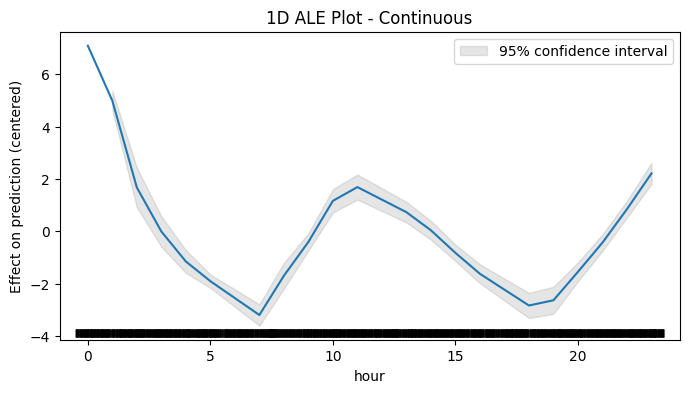

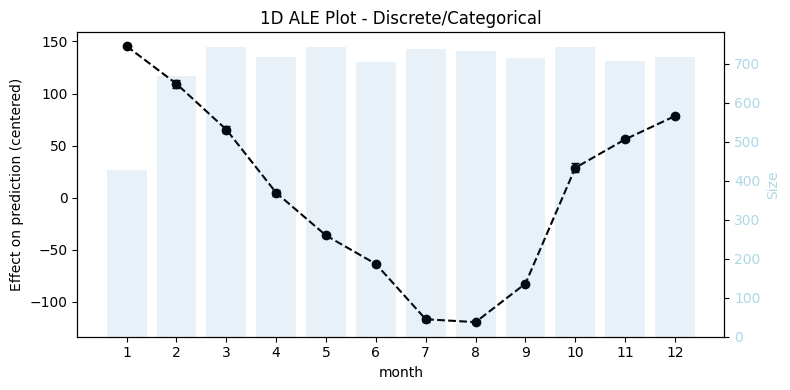

In [13]:
from PyALE import ale

for feat in numeric_for_pdp:
    print(f"Computing ALE for {feat}")
    _ = ale(
        X=X_test,
        model=pipe,
        feature=[feat],
        grid_size=20,
        plot=True
    )


The 1D ALE plots provide a more reliable view compared to PDP, since ALE only computes effects within regions of the data that actually exist. For `temp`, ALE shows a strong decline in PM2.5 between 0-10°C, but the curve smooths out after that. `dewp` displays a consistent positive effect, where higher dew points (more humidity) increase PM2.5, though the slope levels off at the upper end. For `pres`, ALE highlights subtle but non-linear effects from 1005-1025 hPa. `iws` shows a robust negative effect, with stronger winds reducing PM2.5 almost monotonically. Temporal features behave as expected. `hour` has minimal but cyclical influence, while `month` shows higher pollution in winter and lower values in summer.  


##2D ALE (to account for correlation)

Computing 2D ALE for (temp, iws) ...
Computing 2D ALE for (temp, dewp) ...
Computing 2D ALE for (iws, pres) ...


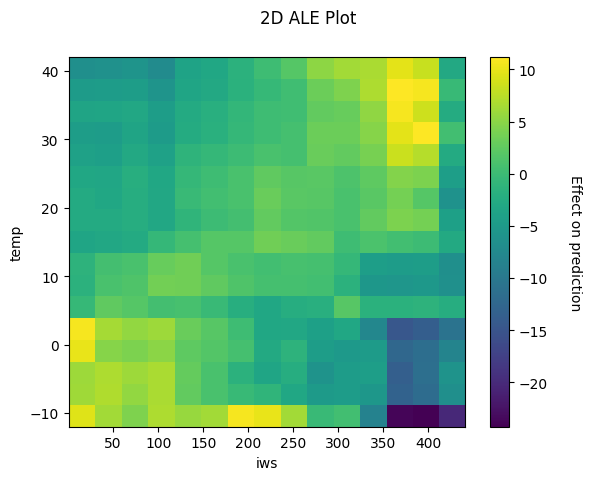

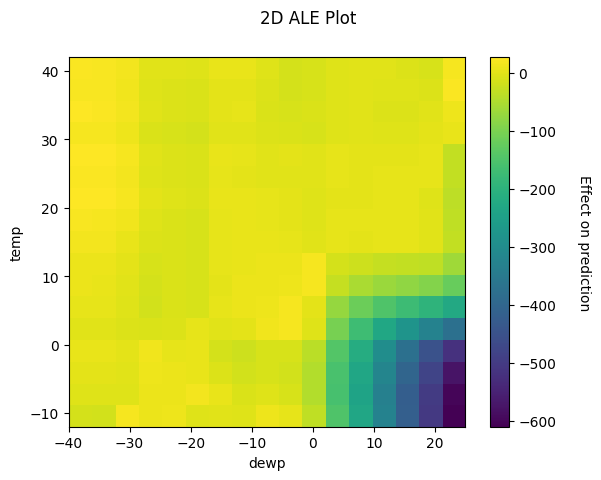

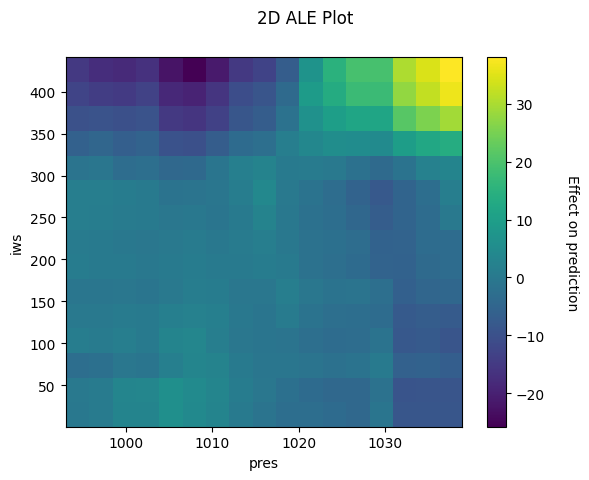

In [16]:
pairs = [
    ("temp", "iws"),
    ("temp", "dewp"),
    ("iws", "pres")
]

for f1, f2 in pairs:
    if f1 in X_test.columns and f2 in X_test.columns:
        print(f"Computing 2D ALE for ({f1}, {f2}) ...")
        _ = ale(
            X=X_test,
            model=pipe,
            feature=[f1, f2],
            grid_size=16,
            plot=True
        )


The 2D ALE plots highlight how pairs of features jointly affect PM2.5 predictions while accounting for correlations. Interestingly, the 2D ALE plot for temperature x dew point shows a region (low temperature, high dew point) where predicted PM2.5 is much lower than average. This might reflect meteorological events like snow, which occur in cold, humid conditions and efficiently remove particulates from the atmosphere. While counterintuitive at first, this illustrates how ALE can uncover feature interactions that are consistent with real-world processes, though also potentially shaped by data sparsity in certain regions. Low wind speed with mid-range pressure leads to the better air quality, but extremely high wind speeds with high pressure leads to worse air quality. Low temperatures temperature and higher wind speed also decreases the prediction majorly.


#Overall Explanation

Overall, the correlation matrix, PDP, ICE, and ALE plots provide complementary perspectives on how meteorological factors influence air quality. PDPs reveal clear global patterns such as the negative effect of wind speed and the seasonal cycle in PM2.5, but can be misleading when features are correlated. ICE plots uncover heterogeneity across individual conditions, showing that not all samples respond in the same way to changes in temperature, dew point, or pressure. 2D ALE plots offer the most reliable global view, correcting for correlation and data sparsity, and confirming that strong winds consistently reduce pollution, humidity raises it, and seasonal cycles dominate temporal effects. By combining these techniques, the broad trends and the interactions that shape PM2.5 can be evaluated.

#Citation

The code for PDP and ICE plots were generated by ChatGPT on 9/28/25. Additionally, whichever code blocks have a comment on the top signifying LLM usage are also generated by ChatGPT.